# Exploring the Dataset

Import and install all-important libraries

In [15]:
#Checking for GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Wed Oct 20 23:51:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                

In [2]:
!pip install emoji

     |████████████████████████████████| 170 kB 7.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=7c6676d215702acd743845a0142e50d159fc3b86c0efc65fd8bf8902836d162d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [3]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
nltk.download('stopwords')
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
import emoji


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Read data from local folder in private google drive. 
Hint: before run this cell you have to change path 

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bootcamp/ASAD/ASAD.csv',  sep=',')
data.head()

,Unnamed: 0,id,text,sentiment
0,0,1223397855903277056,اللي يخسرك من أول غلطه أعرف أنه كان ينطرها من ...,Neutral
1,1,1143297865445457920,مباراة اوروجواي وتشيلي بث مباشر\nكوبا امريكا 2...,Neutral
2,2,1221882773272657920,ربّــاه ! هذا الحنين يُرهِـقُني \nاجمـعني بأبـ...,Neutral
3,3,1143248282703060992,#الطايف\nنقوم بحذف الأسماء المسيئة\nمن برنامج ...,Neutral
4,4,1242908498427592704,الشخص المصاب بفيروس الانفلونزا لا يصاب بفيروس ...,Positive


In [5]:
# delete unimportant columns
data.pop('Unnamed: 0') 
data.pop('id') 

data.head()

,text,sentiment
0,اللي يخسرك من أول غلطه أعرف أنه كان ينطرها من ...,Neutral
1,مباراة اوروجواي وتشيلي بث مباشر\nكوبا امريكا 2...,Neutral
2,ربّــاه ! هذا الحنين يُرهِـقُني \nاجمـعني بأبـ...,Neutral
3,#الطايف\nنقوم بحذف الأسماء المسيئة\nمن برنامج ...,Neutral
4,الشخص المصاب بفيروس الانفلونزا لا يصاب بفيروس ...,Positive


In [6]:
# check if there is a null value
data.isnull().sum()

text          8
sentiment    14
dtype: int64

In [7]:
# drop null value and check again
data.dropna(inplace=True)

data.isnull().sum()

text         0
sentiment    0
dtype: int64

In [8]:
# check the length of the dataset
len(data)

99894

In [9]:
# check the number of samples in each class
temp = data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,Neutral,69299
0,Negative,15326
2,Positive,15269


# EDA 

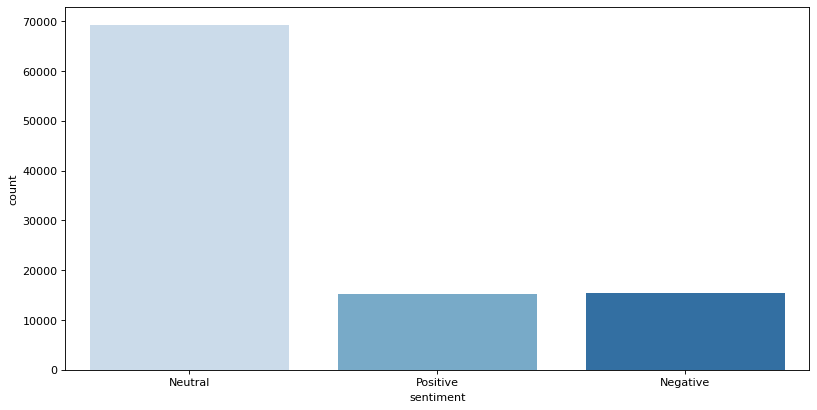

In [ ]:
# plot number of samples in each class
plt.figure(figsize=(12,6),dpi=80)
sns.countplot(x='sentiment',data=data, palette='Blues')

In [9]:
# add new column for number of words in each tweet
data['Num_word_text'] = data['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
data.head()

,text,sentiment,Num_word_text
0,اللي يخسرك من أول غلطه أعرف أنه كان ينطرها من ...,Neutral,11
1,مباراة اوروجواي وتشيلي بث مباشر\nكوبا امريكا 2...,Neutral,13
2,ربّــاه ! هذا الحنين يُرهِـقُني \nاجمـعني بأبـ...,Neutral,9
3,#الطايف\nنقوم بحذف الأسماء المسيئة\nمن برنامج ...,Neutral,12
4,الشخص المصاب بفيروس الانفلونزا لا يصاب بفيروس ...,Positive,22


In [10]:
print('Number of samples :', len(data))
# delete tweet that have number of words less than 3
data = data[data.Num_word_text > 3 ]
print('Number of samples after deleting the short tweets', len(data))

Number of samples : 99894
Number of samples after deleting the short tweets 99869


## Text pre-processing


In [10]:
# This function from https://towardsdatascience.com/arabic-sentiment-analysis-5e21b77fb5ea
'''
The first step is to subject the data to preprocessing.
This involves removing both arabic and english punctuation
Normalizing different letter variants with one common letter
'''
# first we define a list of arabic and english punctiations that we want to get rid of in our text

punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

# Arabic stop words with nltk
stop_words = stopwords.words()

arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    return text

stop_words_normlized = []
for i in stop_words:
  stop_words_normlized.append(normalize(i))

def preprocess(text):
    
    '''
    text is an arabic string input
    
    the preprocessed text is returned
    '''
    
    #remove punctuations
    text = text.translate(str.maketrans('.', ' ')) 
    text = text.translate(str.maketrans('_', ' ')) 
    text = text.translate(str.maketrans('•°°•', '    ')) 

    text = text.translate(str.maketrans(' ', ' ', '''-`÷×؛<>()*&^%ـ،\/:"؟,'][{}~¦+|!”…“–ـ''')) # add punctuation here

    # translator = str.maketrans(' ', ' ', punctuations)
    # text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = ' '.join(word for word in text.split() if word not in stop_words_normlized)

    return text
  
def remove_URL(text):
  # remove URL
    text = re.sub('https?://\S+|www\.\S+', '', text)
    return text

def encoded_URL(text):
  # change URL
    text = re.sub('https?://\S+|www\.\S+', 'URL', text)
    return text

def give_emoji_free(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def remove_user_hash(text):
  text = re.sub("#", "", text)
  text = re.sub('@[^\s]+','',text)

  return text

def encoded_user_hash(text):
  text = re.sub("#", "[وسم] ", text)
  text = re.sub('@[^\s]+','[مستخدم]',text)

  return text




In [ ]:
data['clean_text'] = data['text'].apply(lambda x:remove_URL(x))
data['clean_text'] = data['clean_text'].apply(lambda x:give_emoji_free(x))
data['clean_text'] = data['clean_text'].apply(preprocess)
data['clean_text'] = data['clean_text'].apply(remove_user_hash)

data.head(10)

,text,sentiment,Num_word_text,clean_text
0,اللي يخسرك من أول غلطه أعرف أنه كان ينطرها من ...,Neutral,11,اللي يخسرك غلطه اعرف ينطرها
1,مباراة اوروجواي وتشيلي بث مباشر\nكوبا امريكا 2...,Neutral,13,مباراه اوروجواي وتشيلي بث مباشر كوبا امريكا 20...
2,ربّــاه ! هذا الحنين يُرهِـقُني \nاجمـعني بأبـ...,Neutral,9,رباه الحنين يرهقني اجمعني بابي فردوسك
3,#الطايف\nنقوم بحذف الأسماء المسيئة\nمن برنامج ...,Neutral,12,الطايف نقوم بحذف الاسماء المسيءه برنامج النمبر...
4,الشخص المصاب بفيروس الانفلونزا لا يصاب بفيروس ...,Positive,22,الشخص المصاب بفيروس الانفلونزا يصاب بفيروس كور...
5,كنا خايفين احد يترجم للكمتشيات وجو البقر قدمول...,Neutral,16,كنا خايفين يترجم للكمتشيات وجو البقر قدمولهم ا...
6,وكذٰلك أوحينا إليك قرآنا عربيا لتنذر أم القرى ...,Neutral,27,وكذٰلك اوحينا قرانا عربيا لتنذر القري حولها وت...
7,"""إن كان لك نصيب في شيء، سيقلب الله كل الموازين...",Neutral,13,نصيب شيء سيقلب الله الموازين تحصل
8,إرتفاع عدد المصابين بفيروس #كورونا في #لبنان إ...,Neutral,16,ارتفاع عدد المصابين بفيروس كورونا لبنان 479 تس...
9,Mood:\nانا عايز اتكلم بس مش عايز احكي لحد.,Positive,9,Mood عايز اتكلم مش عايز احكي لحد


In [ ]:
print(data.text[5])
print(data.clean_text[5])
print(data.text[9])
print(data.clean_text[9])

كنا خايفين احد يترجم للكمتشيات وجو البقر قدمولهم الخبر بارد مبرد حسبي الله بس
#SuperJuniorInKSA https://t.co/bYrISmRLBo
كنا خايفين يترجم للكمتشيات وجو البقر قدمولهم الخبر بارد مبرد حسبي الله SuperJuniorInKSA
Mood:
انا عايز اتكلم بس مش عايز احكي لحد.
Mood عايز اتكلم مش عايز احكي لحد


## Common words 

In [ ]:
data['temp_list'] = data['clean_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,الله,14067
1,عليكم,10514
2,السلام,9419
3,جده,8986
4,كورونا,8197
5,موسم,5308
6,اللي,5091
7,مكه,3706
8,مصر,2993
9,عندي,2888


In [ ]:
# plt.figure(figsize=(12,6),dpi=200)

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Tweet Text', orientation='h', 
             width=700, height=700,color='Common_words',)
fig.show()

### Common words in each class

In [ ]:
# create separate dataframe for each class
Positive_sent = data[data['sentiment']=='Positive']
Negative_sent = data[data['sentiment']=='Negative']
Neutral_sent = data[data['sentiment']=='Neutral']

In [ ]:
top_positive = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top_positive.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,الله,2139
1,عليكم,1599
2,السلام,1450
3,جده,1387
4,كورونا,1244
5,اللي,796
6,موسم,793
7,مكه,607
8,مصر,481
9,عندي,480


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top_negative = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top_negative.most_common(20))
temp_negative = temp_negative.iloc[0:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
0,الله,2224
1,عليكم,1584
2,السلام,1416
3,جده,1408
4,كورونا,1235
5,موسم,837
6,اللي,740
7,مكه,561
8,مصر,474
9,يوم,422


In [ ]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top_neutral = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top_neutral.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greys')

,Common_words,count
1,عليكم,7331
2,السلام,6553
3,جده,6191
4,كورونا,5718
5,موسم,3678
6,اللي,3555
7,مكه,2538
8,مصر,2038
9,عندي,2002
10,يوم,1927


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Common UNIQUE words in each class

In [ ]:
top_positive_unique_words = top_positive.copy()
for y in list(top_positive):
  if y in top_negative.keys() or y in top_neutral.keys():    
      top_positive_unique_words.pop(y)


In [ ]:
temp_unique_positive = pd.DataFrame(top_positive_unique_words.most_common(20))
temp_unique_positive = temp_unique_positive.iloc[0:,:]
temp_unique_positive.columns = ['Unique words','count']
temp_unique_positive.style.background_gradient(cmap='Greens')


,Unique words,count
0,البيره,4
1,تعتدي,3
2,كلماتنا,3
3,نحتفظ,3
4,التدخلات,3
5,نبرتك,3
6,الطاقم,3
7,لايتحمل,3
8,ورجل,3
9,فالجنه,3


In [ ]:
fig = px.bar(temp_unique_positive, x="count", y="Unique words", title='Most Commmon Unique Positvie Words', orientation='h', 
             width=700, height=700,color='Unique words')
fig.show()

In [ ]:
top_negative_unique_words = top_negative.copy()
for y in list(top_negative):
  if y in top_positive.keys() or y in top_neutral.keys():    
      top_negative_unique_words.pop(y)


In [ ]:
temp_unique_negative = pd.DataFrame(top_negative_unique_words.most_common(20))
temp_unique_negative = temp_unique_negative.iloc[0:,:]
temp_unique_negative.columns = ['Unique words','count']
temp_unique_negative.style.background_gradient(cmap='Reds')


,Unique words,count
0,ماذنبي,5
1,تعفصو,5
2,اجلها,4
3,التيه,4
4,مظهرك,4
5,تخبرني,4
6,لليالي,4
7,البلاك,3
8,خليتو,3
9,يعلقون,3


In [ ]:
fig = px.bar(temp_unique_negative, x="count", y="Unique words", title='Most Commmon Unique Negative Words', orientation='h', 
             width=700, height=700,color='Unique words')
fig.show()

# Algorithms

import and install all necessary libraries for ML and DL algorithms

In [11]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

     |████████████████████████████████| 231 kB 10.3 MB/s 
     |████████████████████████████████| 8.3 MB 32.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 290 kB 76.4 MB/s 
     |████████████████████████████████| 1.7 MB 57.3 MB/s 
     |████████████████████████████████| 1.2 MB 46.4 MB/s 
     |████████████████████████████████| 2.9 MB 30.3 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 65.0 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 62.9 MB/s 
     |████████████████████████████████| 139 kB 76.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 243 kB 58.6 MB/s 
     |████████████████████████████████| 125 kB 71.8 MB/s 
     |████████████████

simpletransformers==0.62.2


In [12]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Embedding, LSTM, Bidirectional

from tensorflow.keras.utils import to_categorical

import gensim

from simpletransformers.classification import ClassificationModel

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

Now we will clean tweets to feed as input for algorithms, we have to apply some different functions.

In [13]:
data['tweet'] = data['text'].apply(encoded_user_hash)
data['tweet'] = data['tweet'].apply(encoded_URL)
data['tweet'] = data['tweet'].apply(preprocess)


## Logistic Regression

### CountVectorizer

In [ ]:
feature = data.tweet
target = data.sentiment
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

cv1 = CountVectorizer()

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)

prediction = lr.predict(X_test_cv1)

print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy score is 0.64
              precision    recall  f1-score   support

    Negative       0.14      0.04      0.07      3051
     Neutral       0.69      0.90      0.78     13871
    Positive       0.15      0.05      0.08      3052

    accuracy                           0.64     19974
   macro avg       0.33      0.33      0.31     19974
weighted avg       0.53      0.64      0.57     19974



### TfidfVectorizer

In [ ]:
feature = data.tweet
target = data.sentiment
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

Tfidf = TfidfVectorizer()

X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf  = Tfidf.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_Tfidf, y_train)


prediction = lr.predict(X_test_Tfidf)

print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy score is 0.69
              precision    recall  f1-score   support

    Negative       0.08      0.00      0.00      3051
     Neutral       0.69      0.99      0.82     13871
    Positive       0.13      0.00      0.01      3052

    accuracy                           0.69     19974
   macro avg       0.30      0.33      0.28     19974
weighted avg       0.51      0.69      0.57     19974



## Random Forest Classifier

In [ ]:
feature = data.tweet
target = data.sentiment
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

Tfidf = TfidfVectorizer()

X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf  = Tfidf.transform(X_test)

RF = RandomForestClassifier()
RF.fit(X_train_Tfidf, y_train)


prediction = RF.predict(X_test_Tfidf)

print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.66
              precision    recall  f1-score   support

    Negative       0.16      0.03      0.05      3051
     Neutral       0.69      0.94      0.80     13871
    Positive       0.15      0.03      0.06      3052

    accuracy                           0.66     19974
   macro avg       0.34      0.33      0.30     19974
weighted avg       0.53      0.66      0.57     19974



## Support Vector Machine

In [ ]:
feature = data.tweet
target = data.sentiment
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

pipe = make_pipeline(TfidfVectorizer(),
                     SVC())
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],
             'svc__gamma': [0.1, 1, 10, 100],
             'svc__C': [0.1, 1, 10, 100]}

svc_model = GridSearchCV(pipe, param_grid, cv=3)
svc_model.fit(X_train, Y_train)

prediction = svc_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

## BiLSTM

### word2vec (skip-gram)

In [17]:
data['sentiment_encoded'] = data['sentiment'].map({'Negative':0, 'Positive':1, 'Neutral':2 })
y = data['sentiment_encoded']
X = [tweet for tweet in data['tweet']]


In [21]:
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index)+1
encoded_docs = t.texts_to_sequences(X)

word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

max_length = max([len(sublist.split()) for sublist in X])
print('Max length =' , (max_length))


tweets_pad = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


print('Shape of review tensor:', tweets_pad.shape)
print('Shape of sentment tensor:', y.shape )

# you have to downloud full_grams_sg_300_twitter 
aravec = gensim.models.Word2Vec.load('/content/drive/MyDrive/aravec/full_grams_sg_300_twitter/full_grams_sg_300_twitter.mdl')

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = aravec.wv.get_vector(word)
        embedding_matrix[i] = embedding_vector
        
    except KeyError:
        continue



Found 142573 unique tokens.
Max length = 33
Shape of review tensor: (99869, 33)
Shape of sentment tensor: (99869,)


### BiLSTM model

In [29]:
x_train , x_test, y_train , y_test = train_test_split(tweets_pad, y,  
                                                          random_state=42,
                                                          stratify = y,
                                                          test_size=0.20)
# Bi-LSTM model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(100,dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(100,dropout=0.5)))
model.add(Dense(3, activation='softmax'))

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 300)           42772200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 33, 200)           320800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 43,334,403
Trainable params: 562,203
Non-trainable params: 42,772,200
_________________________________________________________________


In [30]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=50)


Epoch 1/5
1598/1598 [==============================] - 348s 213ms/step - loss: 0.8317 - accuracy: 0.6935
Epoch 2/5
1598/1598 [==============================] - 342s 214ms/step - loss: 0.8294 - accuracy: 0.6937
Epoch 3/5
1598/1598 [==============================] - 342s 214ms/step - loss: 0.8287 - accuracy: 0.6937
Epoch 4/5
1598/1598 [==============================] - 342s 214ms/step - loss: 0.8283 - accuracy: 0.6937
Epoch 5/5
1598/1598 [==============================] - 342s 214ms/step - loss: 0.8277 - accuracy: 0.6937


In [31]:
predected = model.predict(x_test)
preds = np.argmax(predected, axis = 1)
# target_names = ['Assertion', 'Expression', 'Miscellaneous','Question', 'Request']
print(classification_report(y_test, preds)) #, target_names=target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3065
           1       0.00      0.00      0.00      3052
           2       0.69      1.00      0.82     13857

    accuracy                           0.69     19974
   macro avg       0.23      0.33      0.27     19974
weighted avg       0.48      0.69      0.57     19974



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## BERT

In [17]:
data['sentiment_encoded'] = data['sentiment'].map({'Negative':0, 'Positive':1, 'Neutral':2 })
df = data[['tweet', 'sentiment_encoded']]

train_df, test_df = train_test_split(df, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (79915, 2)
test shape:  (19979, 2)


In [18]:
# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":True,
             'use_cuda': False,
             "num_train_epochs": 5}

# Create a ClassificationModel
qarib_model = ClassificationModel(
    "bert", "qarib/bert-base-qarib",
    num_labels=3,
    args=train_args,
)

# Train the model
qarib_model.train_model(train_df)


from sklearn.metrics import f1_score, accuracy_score

# target_names = ['Assertion', 'Expression', 'Miscellaneous','Question', 'Request']
report = {}
def f1_multiclass(labels, preds):
    report = classification_report(labels,preds )
    print(report)
    # print(pd.DataFrame(report))
    # cm = confusion_matrix(labels, preds)
    # print(pd.DataFrame(cm, columns=target_names, index=target_names))

    return f1_score(labels, preds, average='macro') 
   
result, model_outputs, wrong_predictions = qarib_model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)



Some weights of the model checkpoint at qarib/bert-base-qarib were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

  0%|          | 0/79915 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:922: FutureWarning:

Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.



Running Epoch 1 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



  0%|          | 0/19979 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2498 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3070
         1.0       0.00      0.00      0.00      3106
         2.0       0.69      1.00      0.82     13803

    accuracy                           0.69     19979
   macro avg       0.23      0.33      0.27     19979
weighted avg       0.48      0.69      0.56     19979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



In [20]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 5}

# Create a ClassificationModel
arabertv02_model = ClassificationModel(
    "bert", "aubmindlab/bert-base-arabertv02",
    num_labels=3,
    args=train_args,
)


# Train the model
arabertv02_model.train_model(train_df)


from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

# target_names = ['Assertion', 'Expression', 'Miscellaneous','Question', 'Request']
def f1_multiclass(labels, preds):
    report = classification_report(labels,preds)
    # ,target_names=target_names )
    print(report)
    # print(pd.DataFrame(report))
    # cm = confusion_matrix(labels, preds)
    # print(pd.DataFrame(cm, columns=target_names, index=target_names))

    return f1_score(labels, preds, average='macro') 
    
result, model_outputs, wrong_predictions = arabertv02_model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



  0%|          | 0/79915 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/9990 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



  0%|          | 0/19979 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2498 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3070
         1.0       0.00      0.00      0.00      3106
         2.0       0.69      1.00      0.82     13803

    accuracy                           0.69     19979
   macro avg       0.23      0.33      0.27     19979
weighted avg       0.48      0.69      0.56     19979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



{'acc': 0.6908754191901496,
 'eval_loss': 0.8343676201838126,
 'f1': 0.2723935823811497,
 'mcc': 0.0}